In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


import itertools

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from mlxtend.plotting import plot_decision_regions

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer, MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.utils import resample

In [2]:
df_clients = pd.read_csv('data/D_clients.csv')
df_close_loan = pd.read_csv('data/D_close_loan.csv')
df_job = pd.read_csv('data/D_job.csv')
df_last_credit = pd.read_csv('data/D_last_credit.csv')
df_loan = pd.read_csv('data/D_loan.csv')
df_salary = pd.read_csv('data/D_salary.csv')
df_target = pd.read_csv('data/D_target.csv')

df_fl_pens = pd.read_csv('data/D_pens.csv')
df_fl_work = pd.read_csv('data/D_work.csv')

In [3]:
df_salary.columns

Index(['FAMILY_INCOME', 'PERSONAL_INCOME', 'ID_CLIENT'], dtype='object')

In [4]:
df_fl_pens

,ID,FLAG,COMMENT
0,1,0,пенсионер
1,2,1,не пенсионер


In [5]:
df_fl_work

,ID,FLAG,COMMENT
0,1,0,работает
1,2,1,не работает
2,3,2,не известно


# Data merging

In [6]:
df_loan2 = df_loan.merge(df_close_loan, on='ID_LOAN')
df_loan_count = df_loan2.groupby(['ID_CLIENT'], as_index=False).agg({'ID_LOAN': 'count', 'CLOSED_FL': 'sum'})
df_loan_count = df_loan_count.rename(columns={'ID_LOAN': 'LOAN_COUNT'})

df_loan_count.head()

,ID_CLIENT,LOAN_COUNT,CLOSED_FL
0,106804370,1,1
1,106804371,1,1
2,106804372,2,1
3,106804373,1,1
4,106804374,2,1


In [7]:
df1 = df_clients.merge(df_salary, left_on='ID', right_on='ID_CLIENT', how='inner')
df1.drop('ID', axis=1, inplace=True)

df2 = df1.merge(df_job)
df3 = df2.merge(df_last_credit)
df4 = df3.merge(df_loan_count)

In [8]:
df4.shape

(15523, 25)

In [9]:
# df4 = df4.drop_duplicates()

In [10]:
df4.shape

(15523, 25)

In [11]:
df_target.head()

,AGREEMENT_RK,ID_CLIENT,TARGET
0,59910150,106804370,0
1,59910230,106804371,0
2,59910525,106804372,0
3,59910803,106804373,0
4,59911781,106804374,0


In [12]:
df4['ID_CLIENT'].head()

0    106805103
1    106809308
2    106805867
3    106808779
4    106814289
Name: ID_CLIENT, dtype: int64

In [13]:
df5 = pd.merge(left=df4, right=df_target, on='ID_CLIENT', how='inner')

In [22]:
df5.head()

,AGE,GENDER,EDUCATION,MARITAL_STATUS,CHILD_TOTAL,DEPENDANTS,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,...,GEN_TITLE,JOB_DIR,WORK_TIME,CREDIT,TERM,FST_PAYMENT,LOAN_COUNT,CLOSED_FL,AGREEMENT_RK,TARGET
0,42,1,Среднее,Не состоял в браке,1,0,1,0,Московская область,Московская область,...,Работник сферы услуг,Участие в основ. деятельности,3.0,5588.0,6,1000.0,1,0,60099204,1
1,28,1,Среднее специальное,Состою в браке,1,1,1,0,Читинская область,Читинская область,...,Специалист,Участие в основ. деятельности,5.0,19498.0,12,0.0,1,0,62244665,0
2,64,0,Среднее специальное,Состою в браке,2,0,1,1,Иркутская область,Иркутская область,...,Руководитель высшего звена,Участие в основ. деятельности,360.0,15470.0,3,15000.0,1,1,61050759,0
3,54,1,Среднее специальное,Состою в браке,0,0,1,0,Новосибирская область,Новосибирская область,...,Специалист,Участие в основ. деятельности,3.0,13960.0,6,2500.0,1,0,62079659,0
4,26,0,Среднее специальное,Состою в браке,1,1,1,0,Красноярский край,Красноярский край,...,Специалист,Участие в основ. деятельности,12.0,11890.0,6,8000.0,2,2,66583553,0


In [24]:
df5.columns = map(str.lower, df5.columns)

In [25]:
df5.head()

,age,gender,education,marital_status,child_total,dependants,socstatus_work_fl,socstatus_pens_fl,reg_address_province,fact_address_province,...,gen_title,job_dir,work_time,credit,term,fst_payment,loan_count,closed_fl,agreement_rk,target
0,42,1,Среднее,Не состоял в браке,1,0,1,0,Московская область,Московская область,...,Работник сферы услуг,Участие в основ. деятельности,3.0,5588.0,6,1000.0,1,0,60099204,1
1,28,1,Среднее специальное,Состою в браке,1,1,1,0,Читинская область,Читинская область,...,Специалист,Участие в основ. деятельности,5.0,19498.0,12,0.0,1,0,62244665,0
2,64,0,Среднее специальное,Состою в браке,2,0,1,1,Иркутская область,Иркутская область,...,Руководитель высшего звена,Участие в основ. деятельности,360.0,15470.0,3,15000.0,1,1,61050759,0
3,54,1,Среднее специальное,Состою в браке,0,0,1,0,Новосибирская область,Новосибирская область,...,Специалист,Участие в основ. деятельности,3.0,13960.0,6,2500.0,1,0,62079659,0
4,26,0,Среднее специальное,Состою в браке,1,1,1,0,Красноярский край,Красноярский край,...,Специалист,Участие в основ. деятельности,12.0,11890.0,6,8000.0,2,2,66583553,0


In [26]:
df5.to_csv('data/client_dataset.csv', index=False)

In [28]:
df6 = pd.read_csv('data/client_dataset.csv')

In [29]:
df6.isna().sum()[df6.isna().sum() > 0]

gen_industry    1397
gen_title       1397
job_dir         1397
work_time       1398
dtype: int64

In [13]:
# df6 = df5.copy()

In [69]:
df6.shape

(15523, 27)

In [70]:
na_cols = df6.columns[df6.isna().sum() > 0]
df6[na_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15523 entries, 0 to 15522
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GEN_INDUSTRY  14126 non-null  object 
 1   GEN_TITLE     14126 non-null  object 
 2   JOB_DIR       14126 non-null  object 
 3   WORK_TIME     14125 non-null  float64
dtypes: float64(1), object(3)
memory usage: 485.2+ KB


In [71]:
df7 = df6.copy()

In [72]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer 

import association_metrics as am
import seaborn as sns

In [73]:
# train, test = train_test_split(df8, test_size=0.25, random_state=42, stratify=df8['TARGET'])

num_features = df7.select_dtypes(include=['int', 'float']).columns
cat_features = df7.select_dtypes(include=['object', 'category']).columns

# df7 = remove_outliers(df7)

data_1 = df7[list(cat_features) + ['TARGET']]
data_2 = df7[num_features]

In [74]:
data_1['TARGET'].value_counts()

0    13670
1     1853
Name: TARGET, dtype: int64

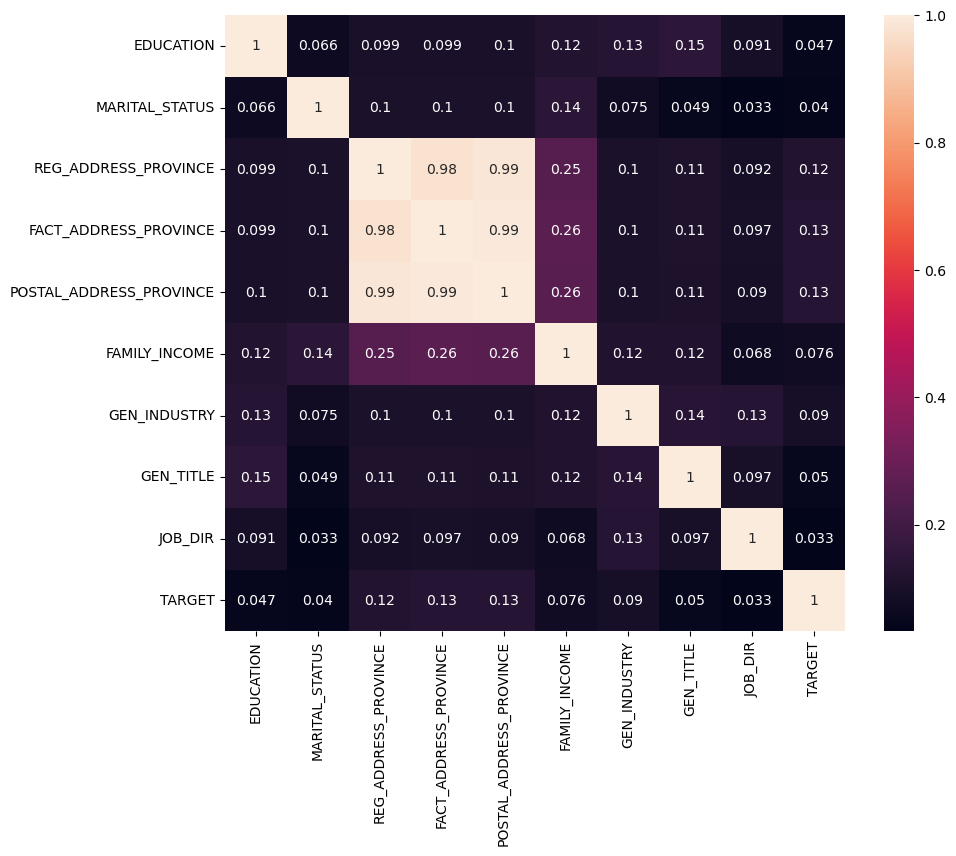

In [75]:
cramersv = am.CramersV(data_1.astype('category'))
cr = cramersv.fit()

plt.figure(figsize=(10, 8))
sns.heatmap(cr, annot=True)
plt.show()

In [77]:
cr

,EDUCATION,MARITAL_STATUS,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,FAMILY_INCOME,GEN_INDUSTRY,GEN_TITLE,JOB_DIR,TARGET
EDUCATION,1.000000,0.065899,0.099039,0.099456,0.100349,0.120859,0.127850,0.146235,0.090929,0.046997
MARITAL_STATUS,0.065899,1.000000,0.101769,0.102013,0.101889,0.143917,0.075021,0.048758,0.032750,0.040479
REG_ADDRESS_PROVINCE,0.099039,0.101769,1.000000,0.975925,0.988477,0.248919,0.102404,0.108379,0.092376,0.121848
FACT_ADDRESS_PROVINCE,0.099456,0.102013,0.975925,1.000000,0.993044,0.259591,0.102509,0.108580,0.096927,0.127960
POSTAL_ADDRESS_PROVINCE,0.100349,0.101889,0.988477,0.993044,1.000000,0.256935,0.102320,0.107371,0.089656,0.128702
FAMILY_INCOME,0.120859,0.143917,0.248919,0.259591,0.256935,1.000000,0.116202,0.118707,0.068411,0.076022
GEN_INDUSTRY,0.127850,0.075021,0.102404,0.102509,0.102320,0.116202,1.000000,0.135089,0.129598,0.090215
GEN_TITLE,0.146235,0.048758,0.108379,0.108580,0.107371,0.118707,0.135089,1.000000,0.096745,0.050410
JOB_DIR,0.090929,0.032750,0.092376,0.096927,0.089656,0.068411,0.129598,0.096745,1.000000,0.032827
TARGET,0.046997,0.040479,0.121848,0.127960,0.128702,0.076022,0.090215,0.050410,0.032827,1.000000


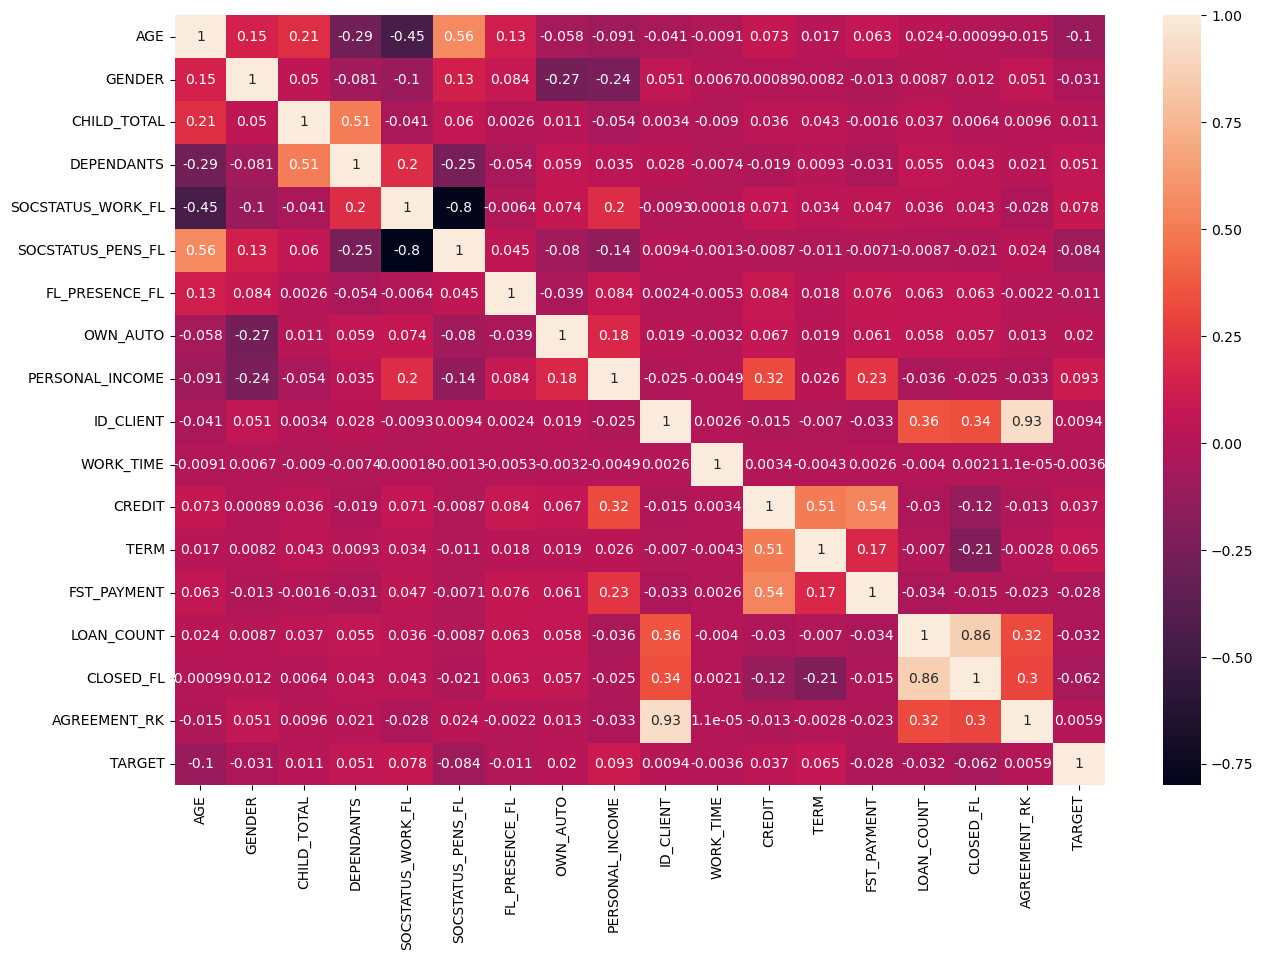

In [76]:
plt.figure(figsize=(15, 10))
sns.heatmap(data_2.corr(), annot=True)
plt.show()

In [26]:
col_to_drop = ['SOCSTATUS_PENS_FL', 
               'CLOSED_FL', 
               'REG_ADDRESS_PROVINCE',
               'POSTAL_ADDRESS_PROVINCE', 
               'AGREEMENT_RK', 
               'ID_CLIENT']

# resample

In [110]:
df8 = df7.drop(col_to_drop, axis=1)

In [111]:
train, test = train_test_split(df8, test_size=0.25, random_state=42, stratify=df8['TARGET'])

In [112]:
def data_resample(df):

    df = df.copy()

    df_min = df[df['TARGET'] == 1]
    df_maj = df[df['TARGET'] == 0]
    
    df_upsample = resample(df_min, replace=True, n_samples=len(df_maj), random_state=42)
    
    df = pd.concat([df_maj, df_upsample], ignore_index=True).sample(frac=1.)
    
    return df

In [113]:
train = data_resample(train)
train.shape

(20116, 21)

In [119]:
X = train.drop('TARGET', axis=1)
y = train['TARGET']

num_features = X.select_dtypes(include=['int', 'float']).columns
cat_features = X.select_dtypes(include=['object', 'category']).columns

In [120]:
imputer = SimpleImputer(strategy='median')
imputer.fit_transform(X[num_features])

array([[2.500e+01, 0.000e+00, 0.000e+00, ..., 6.000e+00, 4.600e+02,
        1.000e+00],
       [6.300e+01, 1.000e+00, 0.000e+00, ..., 6.000e+00, 1.524e+03,
        1.000e+00],
       [3.400e+01, 0.000e+00, 2.000e+00, ..., 1.200e+01, 6.933e+03,
        1.000e+00],
       ...,
       [3.600e+01, 1.000e+00, 2.000e+00, ..., 8.000e+00, 8.500e+03,
        1.000e+00],
       [2.400e+01, 1.000e+00, 1.000e+00, ..., 1.200e+01, 2.500e+03,
        1.000e+00],
       [2.500e+01, 0.000e+00, 0.000e+00, ..., 1.000e+01, 1.000e+03,
        1.000e+00]])

In [121]:
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit_transform(X[cat_features])

array([['Среднее специальное', 'Не состоял в браке',
        'Астраханская область', ..., 'Развлечения/Искусство',
        'Специалист', 'Участие в основ. деятельности'],
       ['Высшее', 'Не состоял в браке', 'Курская область', ...,
        'Торговля', 'Специалист', 'Участие в основ. деятельности'],
       ['Среднее', 'Состою в браке', 'Бурятия', ..., 'Торговля',
        'Индивидуальный предприниматель',
        'Бухгалтерия, финансы, планир.'],
       ...,
       ['Среднее', 'Состою в браке', 'Краснодарский край', ...,
        'Торговля', 'Рабочий', 'Участие в основ. деятельности'],
       ['Среднее специальное', 'Состою в браке', 'Архангельская область',
        ..., 'Здравоохранение', 'Специалист',
        'Участие в основ. деятельности'],
       ['Высшее', 'Не состоял в браке', 'Кабардино-Балкария', ...,
        'Государственная служба', 'Высококвалифиц. специалист',
        'Участие в основ. деятельности']], dtype=object)

In [115]:
numerical_transformer= Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

categorical_transformer= Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])

preprocessor = ColumnTransformer(transformers=[
    ('numerical', numerical_transformer, num_features),
    ('categorical', categorical_transformer, cat_features)
])

X = preprocessor.fit_transform(X)

In [117]:
X.toarray()

array([[-1.24623313, -1.32542421, -1.1014699 , ...,  0.        ,
         1.        ,  0.        ],
       [ 2.15983858,  0.75447543, -1.1014699 , ...,  0.        ,
         1.        ,  0.        ],
       [-0.43953193, -1.32542421,  0.85423587, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.260265  ,  0.75447543,  0.85423587, ...,  0.        ,
         1.        ,  0.        ],
       [-1.33586659,  0.75447543, -0.12361702, ...,  0.        ,
         1.        ,  0.        ],
       [-1.24623313, -1.32542421, -1.1014699 , ...,  0.        ,
         1.        ,  0.        ]])

In [100]:
# res = 0
# # for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
# for C in np.arange(1, 11, 3):
#     clf = SVC(C=C, kernel='linear')
#     scores = cross_val_score(clf, X, y, cv=4, scoring='roc_auc')
#     if scores.mean() > res:
#         res = scores.mean()

#         print(C)
#         print(scores, scores.mean())
#         print()

In [99]:
res = 0
for kernel in ['poly', 'rbf', 'sigmoid']:
    clf = SVC(C=9, kernel=kernel)
    scores = cross_val_score(clf, X, y, cv=4, scoring='roc_auc')
    if scores.mean() > res:
        res = scores.mean()

        print(kernel)
        print(scores, scores.mean())
        print()

poly
[0.97225304 0.97134188 0.97012151 0.97001571] 0.9709330334619174

rbf
[0.98852201 0.98477726 0.98575801 0.98743134] 0.9866221525263692



In [36]:
import optuna

In [102]:
# def objective(trial):
      
#         solver = trial.suggest_categorical("solver", ["liblinear", "lbfgs"])
#         C = trial.suggest_float("C", 0.001, 30.0, log=True)

#         model = LogisticRegression(solver=solver, C=C, random_state=42, max_iter=1000)

#         accuracy = cross_val_score(model, X, y, scoring='roc_auc', cv=4, n_jobs=-1).mean()

#         return accuracy 

# study = optuna.create_study(direction="maximize") 
# study.optimize(objective, n_trials=100) 

# print(f"Best trial: {study.best_trial.value}")
# print(f"Best parameters: {study.best_trial.params}")

In [103]:
x_test = test.drop('TARGET', axis=1)
y_test = test['TARGET']

x_test = preprocessor.transform(x_test)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [104]:
lr = LogisticRegression(C=1.1780126533834017,
                       solver='lbfgs')

lr.fit(X, y)

lr_pred = lr.predict(x_test)

print(roc_auc_score(y_test, lr_pred))

0.6102722414575198


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [105]:
print(accuracy_score(y_test, lr_pred))

0.6127167630057804


In [106]:
print(confusion_matrix(y_test, lr_pred))

[[2057 1296]
 [ 178  275]]


In [107]:
clf = SVC(C=9, kernel='rbf')

clf.fit(X, y)

clf_pred = clf.predict(x_test)

print(roc_auc_score(y_test, clf_pred))

0.5322283955128319


In [108]:
print(accuracy_score(y_test, clf_pred))

0.8200210194429848


In [109]:
print(confusion_matrix(y_test, clf_pred))

[[3051  302]
 [ 383   70]]


In [46]:
df9 = df7.drop(col_to_drop, axis=1)

In [47]:
X = df9.drop('TARGET', axis=1)
y = df9['TARGET']

num_features = X.select_dtypes(include=['int', 'float']).columns
cat_features = X.select_dtypes(include=['object', 'category']).columns

In [48]:
numerical_transformer= Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

categorical_transformer= Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])

preprocessor = ColumnTransformer(transformers=[
    ('numerical', numerical_transformer, num_features),
    ('categorical', categorical_transformer, cat_features)
])

X = preprocessor.fit_transform(X)

In [49]:
clf_pred = clf.predict(X)

print(roc_auc_score(y, clf_pred))

0.9900305266524483


In [50]:
print(accuracy_score(y, clf_pred))

0.9828548906260264


In [51]:
print(confusion_matrix(y, clf_pred))

[[13151   260]
 [    1  1811]]


In [107]:
for model in models:
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor1),
        ('classifier', model)
    ])

    score = cross_val_score(pipe, x, y, scoring='roc_auc')
    print(model.__class__.__name__)
    print(score)
    print(score.mean())
    print()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


LogisticRegression
[0.67020212 0.64215369 0.64300394 0.67436172 0.67712724]
0.6613697402127265



/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


SVC
[0.56606537 0.55881471 0.59387529 0.57455783 0.60119438]
0.5789015142427585



In [17]:
# df7.loc[df7['CHILD_TOTAL'] > 2, 'CHILD_TOTAL'] = 3
# df7.loc[df7['DEPENDANTS'] > 2, 'DEPENDANTS'] = 3

In [124]:
cat_cols = df7.columns[df7.dtypes == 'object']
num_cols = df7.columns[df7.dtypes != 'object']
cat_cols

Index(['EDUCATION', 'MARITAL_STATUS', 'REG_ADDRESS_PROVINCE',
       'FACT_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE', 'FAMILY_INCOME',
       'GEN_INDUSTRY', 'GEN_TITLE', 'JOB_DIR'],
      dtype='object')

In [125]:
def remove_outliers(df):
    df = df.copy()
    
    def quantile(data):
        q25 = data.quantile(0.25)
        q75 = data.quantile(0.75)
        iqr = q75 - q25
    
        return q25 - iqr*1.5, q75 + iqr*1.5

    for col in num_features:
        _, high = quantile(df[col])
        df.loc[df[col] > high1, col] = high1

    return df

In [218]:
num_features

Index(['AGE', 'GENDER', 'CHILD_TOTAL', 'DEPENDANTS', 'SOCSTATUS_WORK_FL',
       'FL_PRESENCE_FL', 'OWN_AUTO', 'PERSONAL_INCOME', 'WORK_TIME', 'CREDIT',
       'TERM', 'FST_PAYMENT', 'LOAN_COUNT'],
      dtype='object')

In [127]:
_, high1 = quantile(df7['WORK_TIME'])
_, high2 = quantile(df7['FST_PAYMENT'])
_, high3 = quantile(df7['PERSONAL_INCOME'])
_, high4 = quantile(df7['CREDIT'])
_, high5 = quantile(df7['TERM'])

In [128]:
df7.loc[df7['WORK_TIME'] > high1, 'WORK_TIME'] = high1
df7.loc[df7['FST_PAYMENT'] > high2, 'FST_PAYMENT'] = high2
df7.loc[df7['PERSONAL_INCOME'] > high3, 'PERSONAL_INCOME'] = high3
df7.loc[df7['CREDIT'] > high4, 'CREDIT'] = high4
df7.loc[df7['TERM'] > high5, 'TERM'] = high5

In [129]:
df7['FST_PAYMENT'] = pd.qcut(df7['PERSONAL_INCOME'], 5, [1, 2, 3, 4, 5]).astype(int)

In [130]:
df7['PERSONAL_INCOME'] = pd.qcut(df7['PERSONAL_INCOME'], 5, [1, 2, 3, 4, 5]).astype(int)
df7['AGE'] = pd.qcut(df7['AGE'], 5, [1, 2, 3, 4, 5]).astype(int)
# df7['FST_PAYMENT'] = pd.qcut(df7['PERSONAL_INCOME'], 5, [1, 2, 3, 4, 5]).astype(int)
df7['CREDIT'] = pd.qcut(df7['CREDIT'], 5, [1, 2, 3, 4, 5]).astype(int)
df7['WORK_TIME'] = pd.qcut(df7['WORK_TIME'], 5, [1, 2, 3, 4, 5]).astype(int)

In [131]:
# for i in cat_cols:
#     print(i)
#     print(df7[i].value_counts())
#     print()

In [132]:
col_to_drop = ['REG_ADDRESS_PROVINCE', 'EDUCATION', 'MARITAL_STATUS',
               'GEN_TITLE', 'FACT_ADDRESS_PROVINCE', 'OWN_AUTO',
               'POSTAL_ADDRESS_PROVINCE', 'GEN_INDUSTRY', 'JOB_DIR']

In [15]:
# ed_cols_1 = ['Среднее', 'Неполное среднее', 'Неоконченное высшее', 'Среднее специальное']
# ed_cols_2 = ['Высшее', 'Два и более высших образования', 'Ученая степень']

# for col in ed_cols_1:
#     df7.loc[df7['EDUCATION'] == col, 'EDUCATION'] = 'Среднее'

# for col in ed_cols_2:
#     df7.loc[df7['EDUCATION'] == col, 'EDUCATION'] = 'Высшее'

In [1022]:
# ed_cols_1 = ['Состою в браке', 'Гражданский брак']
# ed_cols_2 = ['Не состоял в браке']
# ed_cols_3 = ['Разведен(а)', 'Вдовец/Вдова']

# for col in ed_cols_1:
#     df7.loc[df7['MARITAL_STATUS'] == col, 'MARITAL_STATUS'] = 'В браке'

# for col in ed_cols_2:
#     df7.loc[df7['MARITAL_STATUS'] == col, 'MARITAL_STATUS'] = 'Не в браке'

# for col in ed_cols_3:
#     df7.loc[df7['MARITAL_STATUS'] == col, 'MARITAL_STATUS'] = 'Был в браке'

In [1023]:
# ed_cols_1 = ['Рабочий', 'Работник сферы услуг']
# ed_cols_2 = ['Специалист', 'Высококвалифиц. специалист']
# ed_cols_3 = ['Руководитель среднего звена', 'Руководитель высшего звена']
# ed_cols_4 = ['Партнер', 'Индивидуальный предприниматель']
# ed_cols_5 = ['Пенсионер', 'Другое']
# ed_cols_6 = ['Служащий', 'Военнослужащий по контракту', 'Руководитель низшего звена']



# for col in ed_cols_1:
#     df7.loc[df7['GEN_TITLE'] == col, 'GEN_TITLE'] = 'Рабочий'

# for col in ed_cols_2:
#     df7.loc[df7['GEN_TITLE'] == col, 'GEN_TITLE'] = 'Специалист'

# for col in ed_cols_3:
#     df7.loc[df7['GEN_TITLE'] == col, 'GEN_TITLE'] = 'Руководитель'

# for col in ed_cols_4:
#     df7.loc[df7['GEN_TITLE'] == col, 'GEN_TITLE'] = 'ИП'

# for col in ed_cols_5:
#     df7.loc[df7['GEN_TITLE'] == col, 'GEN_TITLE'] = 'Другое'

# for col in ed_cols_6:
#     df7.loc[df7['GEN_TITLE'] == col, 'GEN_TITLE'] = 'Служащий'

In [197]:
df8 = df7.drop(col_to_drop, axis=1)

In [198]:
df8.head()

,AGE,GENDER,CHILD_TOTAL,DEPENDANTS,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,FL_PRESENCE_FL,FAMILY_INCOME,PERSONAL_INCOME,ID_CLIENT,WORK_TIME,CREDIT,TERM,FST_PAYMENT,LOAN_COUNT,CLOSED_FL,AGREEMENT_RK,TARGET
0,3,1,1,0,1,0,1,от 20000 до 50000 руб.,5,106805103,1,1,6,5,1,0,60099204,1
1,1,1,1,1,1,0,0,от 10000 до 20000 руб.,2,106809308,1,4,12,2,1,0,62244665,0
2,5,0,2,0,1,1,0,от 20000 до 50000 руб.,5,106805867,5,4,3,5,1,1,61050759,0
3,5,1,0,0,1,0,1,от 20000 до 50000 руб.,5,106808779,1,3,6,5,1,0,62079659,0
4,1,0,1,1,1,0,1,от 10000 до 20000 руб.,4,106814289,1,3,6,4,2,2,66583553,0


In [199]:
df8 = pd.get_dummies(df8, drop_first=True)

In [201]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer, MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.utils import resample

In [188]:
# df7 = df6.drop('AGREEMENT_RK', axis=1)

In [189]:
# df8.to_csv('data/client_dataset_prep.csv', index=False)

In [190]:
# cat_cols = df7.columns[df7.dtypes == 'object']
# num_cols = df7.columns[df7.dtypes != 'object']

In [191]:
# pipe = Pipeline([
#     ('scaler', StandardScaler()),
#     ('model', LogisticRegression())
# ])

In [192]:
# df8 = pd.read_csv('data/client_dataset_prep.csv')

In [195]:
df8 = pd.merge(left=df8, right=df_target, on='ID_CLIENT', how='inner')

In [202]:
X = df8.drop(['AGREEMENT_RK', 'ID_CLIENT', 'TARGET'], axis=1)
y = df8['TARGET']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [203]:
(y.value_counts() / len(y)) * 100

0    88.096959
1    11.903041
Name: TARGET, dtype: float64

In [204]:
df_min = df8[df8['TARGET'] == 1]
df_maj = df8[df8['TARGET'] == 0]

df_upsample = resample(df_min, replace=True, n_samples=len(df_maj), random_state=42)

In [205]:
df_maj.shape

(13411, 21)

In [206]:
df_upsample.shape

(13411, 21)

In [207]:
df_1 = pd.concat([df_maj, df_upsample], ignore_index=True).sample(frac=1.)

In [208]:
df_1.shape

(26822, 21)

In [209]:
df_1 = pd.concat([df_maj, df_upsample], ignore_index=True).sample(frac=1.)
X = df_1.drop(['AGREEMENT_RK', 'ID_CLIENT', 'TARGET'], axis=1)
y = df_1['TARGET']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [210]:
# lr = LogisticRegression(class_weight='balanced')
lr = LogisticRegression(C=24)

lr.fit(x_train, y_train)

lr_pred = lr.predict(x_test)

roc_auc_score(y_test, lr_pred)

0.6182523113629586

In [211]:
confusion_matrix(y_test, lr_pred)

array([[1934, 1419],
       [1141, 2212]])

In [212]:
accuracy_score(y_test, lr_pred)

0.6182523113629586

In [213]:
lr.coef_

array([[-0.16474035,  0.0365808 ,  0.14210083, -0.01346702,  0.01430761,
        -0.110841  , -0.03017003,  0.18342887, -0.26702123, -0.15223385,
         0.23015912,  0.18342887,  0.17094489, -0.2837405 , -0.18958916,
        -0.25224468, -0.10530119, -0.01085388]])

In [168]:
from sklearn.calibration import CalibratedClassifierCV

In [169]:
lr_calibrated = CalibratedClassifierCV(LogisticRegression(C=1), cv=3)

lr_calibrated.fit(x_train, y_train)

CalibratedClassifierCV(cv=3, estimator=LogisticRegression(C=1))

In [170]:
probs_lr_c = lr_calibrated.predict_proba(x_test)[:,1]

probs_lr_c[:10]

array([9.99774012e-01, 9.99762596e-01, 3.88458844e-04, 2.78322237e-04,
       4.31956708e-04, 9.99621789e-01, 9.99747401e-01, 9.99749355e-01,
       3.11385755e-04, 9.99673128e-01])

In [ ]:
res = 0
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    for C in np.arange(0.1, 10, 0.1):
        clf = SVC(C=C, kernel=kernel)
        scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
        if scores.mean() > res:
            res = scores.mean()

            print(kernel, C)
            print(scores, scores.mean())
            print()

In [ ]:
def objective(trial):
      
        solver = trial.suggest_categorical("solver", ["liblinear", "lbfgs"])
        C = trial.suggest_float("C", 0.001, 30.0, log=True)

        model = LogisticRegression(solver=solver, C=C, random_state=42, max_iter=1000)

        accuracy = cross_val_score(model, X, y, scoring='accuracy', cv=5, n_jobs=-1).mean()

        return accuracy 

study = optuna.create_study(direction="maximize") 
study.optimize(objective, n_trials=100) 

print(f"Best trial: {study.best_trial.value}")
print(f"Best parameters: {study.best_trial.params}")

In [171]:
params = [
    { 
    'C' : np.arange(1, 50),                     
    }
]

lr = LogisticRegression()

clf1 = GridSearchCV(estimator = lr, 
                   param_grid = params, 
                   scoring = 'roc_auc', 
                   cv = 3, 
                   verbose=True,
                   n_jobs=-1)

clf_fit1 = clf1.fit(X,y)

print(clf_fit1.best_estimator_, clf_fit1.best_score_)

Fitting 3 folds for each of 49 candidates, totalling 147 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

LogisticRegression(C=18) 0.960189660033854


In [172]:
for trh in np.arange(0.01, 1, 0.01):
    lr_pred = [1 if i > trh else 0 for i in probs_lr_c]
    print(trh)
    print(roc_auc_score(y_test, lr_pred))
    print(accuracy_score(y_test, lr_pred))
    print()

0.01
1.0
1.0

0.02
1.0
1.0

0.03
1.0
1.0

0.04
1.0
1.0

0.05
1.0
1.0

0.060000000000000005
1.0
1.0

0.06999999999999999
1.0
1.0

0.08
1.0
1.0

0.09
1.0
1.0

0.09999999999999999
1.0
1.0

0.11
1.0
1.0

0.12
1.0
1.0

0.13
1.0
1.0

0.14
1.0
1.0

0.15000000000000002
1.0
1.0

0.16
1.0
1.0

0.17
1.0
1.0

0.18000000000000002
1.0
1.0

0.19
1.0
1.0

0.2
1.0
1.0

0.21000000000000002
1.0
1.0

0.22
1.0
1.0

0.23
1.0
1.0

0.24000000000000002
1.0
1.0

0.25
1.0
1.0

0.26
1.0
1.0

0.27
1.0
1.0

0.28
1.0
1.0

0.29000000000000004
1.0
1.0

0.3
1.0
1.0

0.31
1.0
1.0

0.32
1.0
1.0

0.33
1.0
1.0

0.34
1.0
1.0

0.35000000000000003
1.0
1.0

0.36000000000000004
1.0
1.0

0.37
1.0
1.0

0.38
1.0
1.0

0.39
1.0
1.0

0.4
1.0
1.0

0.41000000000000003
1.0
1.0

0.42000000000000004
1.0
1.0

0.43
1.0
1.0

0.44
1.0
1.0

0.45
1.0
1.0

0.46
1.0
1.0

0.47000000000000003
1.0
1.0

0.48000000000000004
1.0
1.0

0.49
1.0
1.0

0.5
1.0
1.0

0.51
1.0
1.0

0.52
1.0
1.0

0.53
1.0
1.0

0.54
1.0
1.0

0.55
1.0
1.0

0.56
1.0
1.0

0.5700000

In [71]:
# lr_pred = [1 if i > 0.12 else 0 for i in probs_lr_c]

In [72]:
lr_pred = lr_calibrated.predict(x_test)

In [73]:
roc_auc_score(y_test, lr_pred)

0.6113927825827618

In [59]:
confusion_matrix(y_test, lr_pred)

array([[1931, 1422],
       [1181, 2172]])

In [60]:
accuracy_score(y_test, lr_pred)

0.6118401431553833

In [61]:
svc = SVC(kernel='linear')

svc.fit(x_train, y_train)

svc_pred = svc.predict(x_test)

roc_auc_score(y_test, svc_pred)

0.6157172681181032

In [62]:
svm_calibrated = CalibratedClassifierCV(SVC(kernel='poly', probability=True), cv=3)

svm_calibrated.fit(x_train, y_train)

CalibratedClassifierCV(cv=3, estimator=SVC(kernel='poly', probability=True))

In [63]:
probs_svm_c = svm_calibrated.predict_proba(x_test)[:,1]

probs_svm_c[:10]

array([0.71411536, 0.68109718, 0.74085005, 0.50989392, 0.64542284,
       0.65226117, 0.39695956, 0.2807224 , 0.36558313, 0.58962433])

In [64]:
x_test.shape

(6706, 18)

In [65]:
svc_pred = svm_calibrated.predict(x_test)
roc_auc_score(y_test, svc_pred)

0.6389800178944228

In [66]:
accuracy_score(y_test, svc_pred)

0.6389800178944229

In [ ]:
'poly'

In [842]:
# for trh in np.arange(0.001, 3, 0.001):
#     lr_pred = [1 if i > trh else 0 for i in probs_svm_c]
#     print(trh)
#     print(roc_auc_score(y_test, lr_pred))
#     print(accuracy_score(y_test, lr_pred))
#     print()

In [ ]:
0.12000000000000001

In [934]:
# for kernel in ['linear', 'sigmoid']:
#     for C in np.arange(1, 3.1, 0.1):

#         svc = SVC(kernel=kernel, C=C)
        
#         svc.fit(x_train, y_train)
        
#         svc_pred = svc.predict(x_test)

#         print(kernel, C)
#         print(roc_auc_score(y_test, svc_pred))
#         print()

In [16]:
# params = [
#     { 
#     'C' : np.arange(0.1, 10, 0.1),                     
#     }
# ]

# clf1 = GridSearchCV(estimator = lr, 
#                    param_grid = params, 
#                    scoring = 'roc_auc', 
#                    cv = 3, 
#                    verbose=True,
#                    n_jobs=-1)

# clf_fit1 = clf1.fit(X,y)

# print(clf_fit1.best_estimator_, clf_fit1.best_score_)

In [206]:
X.shape

(15223, 33)

In [17]:
# for i in np.arange(0.1, 5, 0.1):

#     svc.fit(x_train, y_train)
    
#     svc_pred = svc.predict(x_test)

#     print(i)
#     print(roc_auc_score(y_test, svc_pred))
#     print()

In [28]:
# row = df7.loc[df7['ID_CLIENT'] == 106809308, :].drop('ID_CLIENT', axis=1)
# prediction = pipe.predict(row)
# prediction

array([0])

In [143]:
# import pickle

# with open('models/lr_model.pkl', 'wb') as file:
#     pickle.dump(pipe, file)